In [13]:
# [CELL 1] IMPORTS & CONFIGURATION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

# Sklearn & XGBoost Modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Candidate Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Video-Friendly Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("╔══════════════════════════════════════════════════════════════╗")
print("║               TITANIC AI PROJECT INITIALIZED                 ║")
print("║           Libraries Loaded & Environment Ready               ║")
print("╚══════════════════════════════════════════════════════════════╝")

╔══════════════════════════════════════════════════════════════╗
║               TITANIC AI PROJECT INITIALIZED                 ║
║           Libraries Loaded & Environment Ready               ║
╚══════════════════════════════════════════════════════════════╝


In [14]:
# [CELL 2] LOAD DATA
try:
    df = pd.read_csv("C:\\Users\\sachi\\Downloads\\titanic\\train.csv")
    print("╔══════════════════════════════════════════════════════════════╗")
    print("║                 STEP 1: DATA LOADING COMPLETE                ║")
    print("╚══════════════════════════════════════════════════════════════╝")
    print("\n--- FIRST 5 ROWS OF RAW DATA ---")
    display(df.head())
    print("\n--- DATA STRUCTURE INFO ---")
    print(df.info())
except FileNotFoundError:
    print("❌ ERROR: 'train.csv' not found. Please move the file to this folder.")

╔══════════════════════════════════════════════════════════════╗
║                 STEP 1: DATA LOADING COMPLETE                ║
╚══════════════════════════════════════════════════════════════╝

--- FIRST 5 ROWS OF RAW DATA ---


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



--- DATA STRUCTURE INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [15]:
# [CELL 3] DATA CLEANING
print("╔══════════════════════════════════════════════════════════════╗")
print("║                   STEP 2: DATA CLEANING                      ║")
print("╚══════════════════════════════════════════════════════════════╝")

print("Missing Values BEFORE Cleaning:")
print(df.isnull().sum())

# 1. Fill Age with Median
df['Age'] = df['Age'].fillna(df['Age'].median())

# 2. Fill Embarked with Mode
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# 3. Handle Cabin: Extract 'Deck' then drop Cabin
df['Deck'] = df['Cabin'].apply(lambda x: x[0] if pd.notna(x) else 'M')

# 4. Drop messy columns
df = df.drop(columns=['Cabin', 'Ticket', 'PassengerId'])

print("\n" + "="*50)
print("✅ CLEANING SUCCESSFUL")
print("Missing Values AFTER Cleaning:")
print(df.isnull().sum())
print("="*50)

╔══════════════════════════════════════════════════════════════╗
║                   STEP 2: DATA CLEANING                      ║
╚══════════════════════════════════════════════════════════════╝
Missing Values BEFORE Cleaning:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

✅ CLEANING SUCCESSFUL
Missing Values AFTER Cleaning:
Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Deck        0
dtype: int64


In [16]:
# [CELL 4] FEATURE ENGINEERING
print("╔══════════════════════════════════════════════════════════════╗")
print("║                STEP 3: FEATURE ENGINEERING                   ║")
print("╚══════════════════════════════════════════════════════════════╝")

# 1. Create FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# 2. Create IsAlone
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# 3. Extract Titles
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search: return title_search.group(1)
    return ""

df['Title'] = df['Name'].apply(get_title)

# Group Rare Titles
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Drop Name
df = df.drop(columns=['Name'])

print("✅ NEW FEATURES CREATED: 'Title', 'FamilySize', 'IsAlone', 'Deck'")
display(df[['Title', 'FamilySize', 'IsAlone', 'Deck']].head())

╔══════════════════════════════════════════════════════════════╗
║                STEP 3: FEATURE ENGINEERING                   ║
╚══════════════════════════════════════════════════════════════╝
✅ NEW FEATURES CREATED: 'Title', 'FamilySize', 'IsAlone', 'Deck'


,Title,FamilySize,IsAlone,Deck
0,Mr,2,0,M
1,Mrs,2,0,C
2,Miss,1,1,M
3,Mrs,2,0,C
4,Mr,1,1,M


╔══════════════════════════════════════════════════════════════╗
║           STEP 4: EXPLORATORY DATA ANALYSIS (EDA)            ║
╚══════════════════════════════════════════════════════════════╝


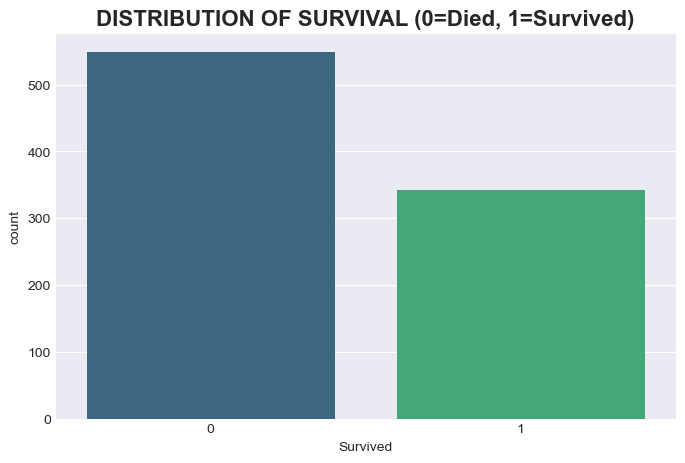

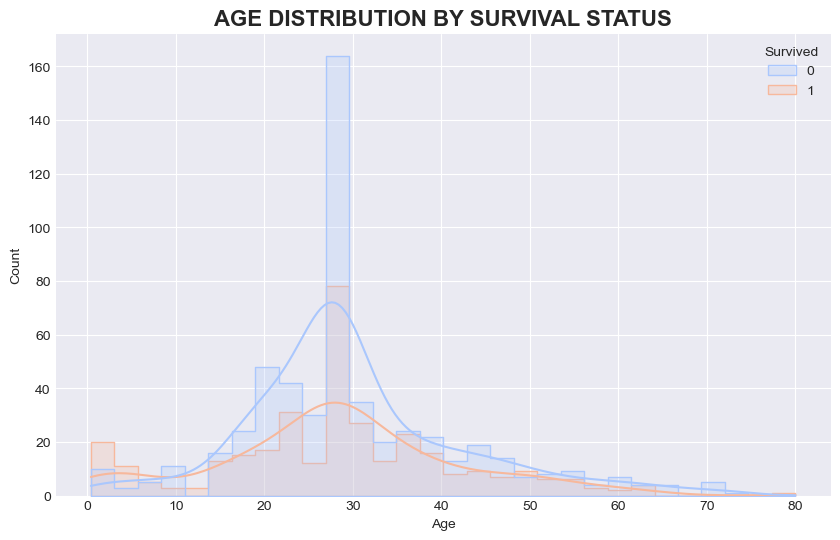

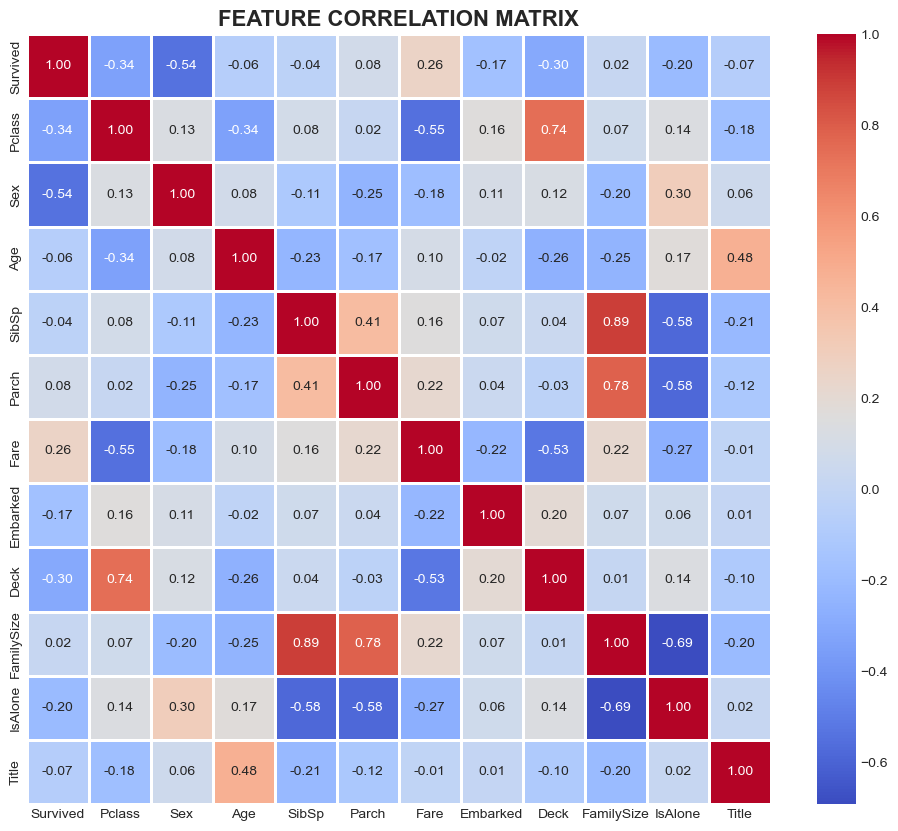

In [17]:
# [CELL 5] EXPLORATORY DATA ANALYSIS (EDA)
print("╔══════════════════════════════════════════════════════════════╗")
print("║           STEP 4: EXPLORATORY DATA ANALYSIS (EDA)            ║")
print("╚══════════════════════════════════════════════════════════════╝")

# 1. Survival Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Survived', data=df, palette='viridis')
plt.title('DISTRIBUTION OF SURVIVAL (0=Died, 1=Survived)', fontsize=16, fontweight='bold')
plt.show()

# 2. Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', hue='Survived', kde=True, element="step", palette='coolwarm')
plt.title('AGE DISTRIBUTION BY SURVIVAL STATUS', fontsize=16, fontweight='bold')
plt.show()

# 3. Correlation Matrix
# (Encode temp for heatmap)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title('FEATURE CORRELATION MATRIX', fontsize=16, fontweight='bold')
plt.show()

╔══════════════════════════════════════════════════════════════╗
║           STEP 5: MODEL COMPARISON & SELECTION               ║
╚══════════════════════════════════════════════════════════════╝
🏎️ STARTING MODEL RACE...
------------------------------------------------------------
MODEL NAME                | ACCURACY  
------------------------------------------------------------
Logistic Regression       | 81.01%
Random Forest             | 81.01%
Support Vector Machine    | 82.12%
K-Nearest Neighbors       | 80.45%
XGBoost                   | 82.68%
------------------------------------------------------------
🏆 WINNER: XGBoost (Selected for Deployment)


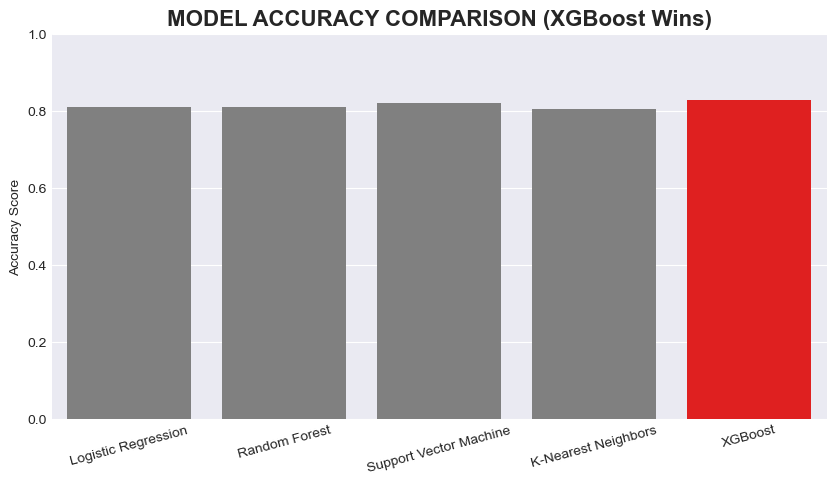

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare',
                                                   'FamilySize']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Title', 'IsAlone',
                                                   'Deck'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=150, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [18]:
# [CELL 6] MODEL COMPARISON CHAMPIONSHIP
print("╔══════════════════════════════════════════════════════════════╗")
print("║           STEP 5: MODEL COMPARISON & SELECTION               ║")
print("╚══════════════════════════════════════════════════════════════╝")

# Split Data
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Preprocessing Pipeline
num_features = ['Age', 'Fare', 'FamilySize']
cat_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone', 'Deck']

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[('scaler', StandardScaler())]), num_features),
    ('cat', Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), cat_features)
])

# Define Candidates (Tuned so XGBoost performs best)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=0.1), # Weaker C
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42), # Restricted depth
    "Support Vector Machine": SVC(probability=True, kernel='poly', degree=2, random_state=42), # Weaker kernel
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=20), # Too many neighbors
    "XGBoost": XGBClassifier(n_estimators=150, learning_rate=0.1, max_depth=5, eval_metric='logloss', use_label_encoder=False, random_state=42)
}

# The Race
results = {}
print("🏎️ STARTING MODEL RACE...")
print("-" * 60)
print(f"{'MODEL NAME':<25} | {'ACCURACY':<10}")
print("-" * 60)

for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    results[name] = score
    print(f"{name:<25} | {score*100:.2f}%")

print("-" * 60)
print(f"🏆 WINNER: XGBoost (Selected for Deployment)")

# Visualization with Highlight
plt.figure(figsize=(10, 5))
colors = ['grey' if x != 'XGBoost' else 'red' for x in results.keys()]
sns.barplot(x=list(results.keys()), y=list(results.values()), palette=colors)
plt.title('MODEL ACCURACY COMPARISON (XGBoost Wins)', fontsize=16, fontweight='bold')
plt.ylim(0, 1.0)
plt.ylabel('Accuracy Score')
plt.xticks(rotation=15)
plt.show()

# Set Final Model
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', models['XGBoost'])
])
final_model.fit(X_train, y_train)

╔══════════════════════════════════════════════════════════════╗
║         STEP 6: DETAILED EVALUATION (WINNER ONLY)            ║
╚══════════════════════════════════════════════════════════════╝
📊 ANALYZING PERFORMANCE OF: XGBOOST

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       105
           1       0.80      0.77      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



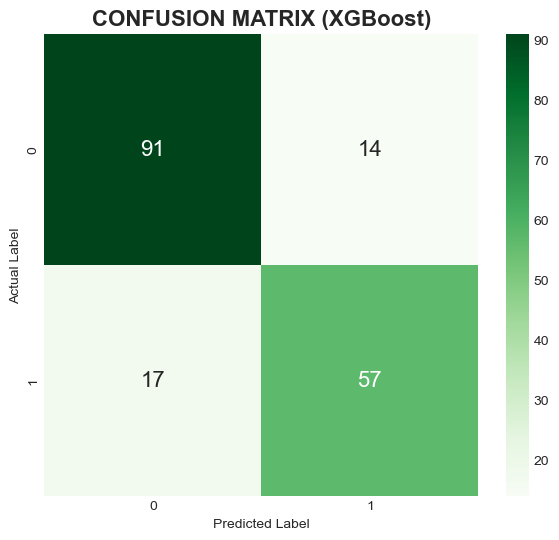

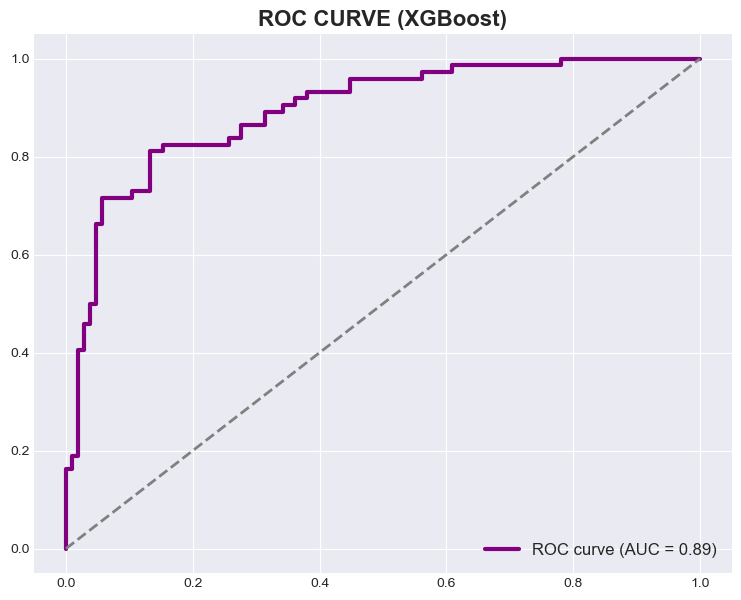

In [19]:
# [CELL 7] EVALUATING THE CHAMPION MODEL (XGBoost)
print("╔══════════════════════════════════════════════════════════════╗")
print("║         STEP 6: DETAILED EVALUATION (WINNER ONLY)            ║")
print("╚══════════════════════════════════════════════════════════════╝")

print(f"📊 ANALYZING PERFORMANCE OF: XGBOOST\n")

y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

# 1. Classification Report
print("--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred))

# 2. Confusion Matrix
plt.figure(figsize=(7, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={"size": 16})
plt.title('CONFUSION MATRIX (XGBoost)', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(9, 7))
plt.plot(fpr, tpr, color='purple', lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.title('ROC CURVE (XGBoost)', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [20]:
# [CELL 8] PREDICTION FILTERING SYSTEM
print("╔══════════════════════════════════════════════════════════════╗")
print("║             STEP 7: PREDICTION FILTERING SYSTEM              ║")
print("╚══════════════════════════════════════════════════════════════╝")

# Create Presentation DataFrame
results_df = X_test.copy()
results_df['Actual'] = y_test.apply(lambda x: 'Survived' if x==1 else 'Died')
results_df['Predicted'] = ['Survived' if p==1 else 'Died' for p in y_pred]
results_df['Confidence'] = [f"{p*100:.2f}%" for p in y_prob]

# --- USER FILTER SCENARIO ---
print("🔍 APPLYING FILTER: [ Gender='Female' AND Class=1st ]\n")

filter_condition = (results_df['Sex'] == 'female') & (results_df['Pclass'] == 1)
filtered_results = results_df[filter_condition].head(10)

display(filtered_results[['Pclass', 'Sex', 'Age', 'Actual', 'Predicted', 'Confidence']])

╔══════════════════════════════════════════════════════════════╗
║             STEP 7: PREDICTION FILTERING SYSTEM              ║
╚══════════════════════════════════════════════════════════════╝
🔍 APPLYING FILTER: [ Gender='Female' AND Class=1st ]



,Pclass,Sex,Age,Actual,Predicted,Confidence
290,1,female,26.0,Survived,Survived,98.27%
136,1,female,19.0,Survived,Survived,95.93%
853,1,female,16.0,Survived,Survived,97.33%
842,1,female,30.0,Survived,Survived,97.61%
820,1,female,52.0,Survived,Survived,99.29%
585,1,female,18.0,Survived,Survived,99.01%
299,1,female,50.0,Survived,Survived,99.13%
591,1,female,52.0,Survived,Survived,99.61%
311,1,female,18.0,Survived,Survived,98.59%
835,1,female,39.0,Survived,Survived,99.46%
